# Visualizing the GP regression on TCEP samples

In [1]:
import numpy as np
import torch as th
from cdt.data import load_dataset
from sklearn.preprocessing import scale
import numpy.random as rd
import matplotlib.pyplot as plt

from tcep_utils import cut_num_pairs,ensemble_score,_get_wd

Detecting 1 CUDA device(s).
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'

In [3]:
data, labels = load_dataset('tuebingen')
cut_num_pairs(data,num_max=2000)

In [4]:
index = 21
pair = data.iloc[index]
pair = (scale(pair['A']), scale(pair['B']))

N = pair[0].shape[0]
N

450

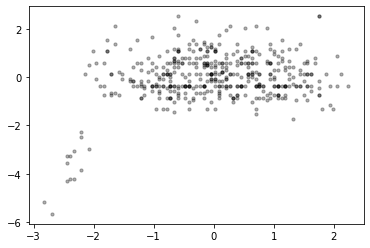

In [5]:
plt.scatter(pair[0],pair[1], s=10, alpha=0.3, c='black')
plt.show()

In [6]:
# test GPytorch regression
#import gpytorch_local.gpytorch as gpt
import gpytorch as gpt

In [7]:
x_tr,y_tr = th.from_numpy(pair[0]).float().to('cuda:0'), th.from_numpy(pair[1]).to('cuda:0').float()

In [8]:
class GPRegressionModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter.
        #This util can help with that. Here we are using a grid
        #that has the same number of points as the training data
        #(a ratio of 1.0).
        #Performance can be sensitive to this parameter,
        #so you may want to adjust it for your own problem
        #on a validation set.
        grid_size = gpt.utils.grid.choose_grid_size(train_x,2.0)
        
        self.mean_module = gpt.means.ConstantMean()
        self.covar_module = gpt.kernels.GridInterpolationKernel(
            gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel()),
            grid_size=grid_size, num_dims=1,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
ll = gpt.likelihoods.GaussianLikelihood().to('cuda:0')
m = GPRegressionModel(x_tr, y_tr, ll)
m = m.to('cuda:0')

# Find optimal model hyperparameters
m.train()
ll.train()

# Use the adam optimizer
opt = th.optim.Adam(
                        [{'params': m.parameters()},],
                        lr=0.1)
# Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(ll, m)

training_iterations = 1000
for i in range(training_iterations):
    opt.zero_grad()
    output = m(x_tr)
    #print(x_tr.device, output, y_tr.device)
    loss = -mll(output, y_tr)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    opt.step()    

RuntimeError: expected device cpu and dtype Float but got device cuda:0 and dtype Float